In [1]:
%reset
%matplotlib inline

import netCDF4 as nc
import cmocean
import numpy as np
import xarray as xr
import xrft
from xgcm import Grid
import matplotlib.pyplot as plt
import scipy.interpolate
from dask.diagnostics import ProgressBar
from matplotlib import colors, ticker
import pandas as pd

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
forcing=xr.open_dataset('NW2_forcing.nc', decode_times=False) #This is for the 1/8 degree case


# #1/4 degree resolution, surface diagnostics are for uppermost 5 meters.
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.25deg_N15_baseline_hmix5/
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc'], decode_times=False)
# av = xr.open_dataset('averages_00031502.nc', decode_times=False)  #100 5-day averages

# #1/8 degree resolution, surface diagnostics are for uppermost 5 meters.
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.125deg_N15_baseline_hmix5/
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc'], decode_times=False)
# av = xr.open_dataset('averages_00004502.nc', decode_times=False)  #100 5-day averages

# #1/16 degree resolution, surface diagnostics are for uppermost 5 meters.
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.0625deg_N15_baseline_hmix5/
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc','sub03/ocean.stats.nc','sub04/ocean.stats.nc',
#                         'sub05/ocean.stats.nc'], decode_times=False)
# av = xr.open_dataset('averages_00004502.nc', decode_times=False)  #100 5-day averages

#1/32 degree resolution, surface diagnostics are for uppermost 5 meters.
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_dataset('sub01/ocean.stats.nc', decode_times=False)
#os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc','sub03/ocean.stats.nc','sub04/ocean.stats.nc',
#                        'sub05/ocean.stats.nc','sub06/ocean.stats.nc','sub07/ocean.stats.nc','sub08/ocean.stats.nc'], decode_times=False)
av = xr.open_dataset('averages_00002702.nc', decode_times=False)  #20 5-day averages
#av = xr.open_mfdataset(['averages_00000502.nc','averages_00000602.nc','averages_00000702.nc','averages_00000802.nc','averages_00000902.nc'], decode_times=False)  #20 5-day averages
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis
/glade/campaign/univ/unyu0004/NeverWorld2/nw2_0.03125deg_N15_baseline_hmix5
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [3]:
lon=fs['geolon']; lat=fs['geolat']
    

Ld = av.Rd1[:].mean('time')
grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
#Interpolating u,v to be on the same grid points:
dx= grid.interp(fs.dxCu,axis='X')
dy= grid.interp(fs.dyCv,axis='Y')

Ld = av.Rd1[:].mean('time').mean('xh')/1000

In [4]:
print('min dx:',2*np.pi*6378000*np.cos(70*np.pi/180)/360/32,'km')
print('max dx:',2*np.pi*6378000/360/32,'km')

min dx: 1189.7715747288576 km
max dx: 3478.6593653811983 km


In [5]:
lat.shape

(4480, 1920)

In [6]:
lon.shape

(4480, 1920)

In [9]:
SSH = (av['h'][:,:,:,:]).sum('zl')-(av['h'][:,:,:,:]).sum('zl').mean('time');
print('done')

done


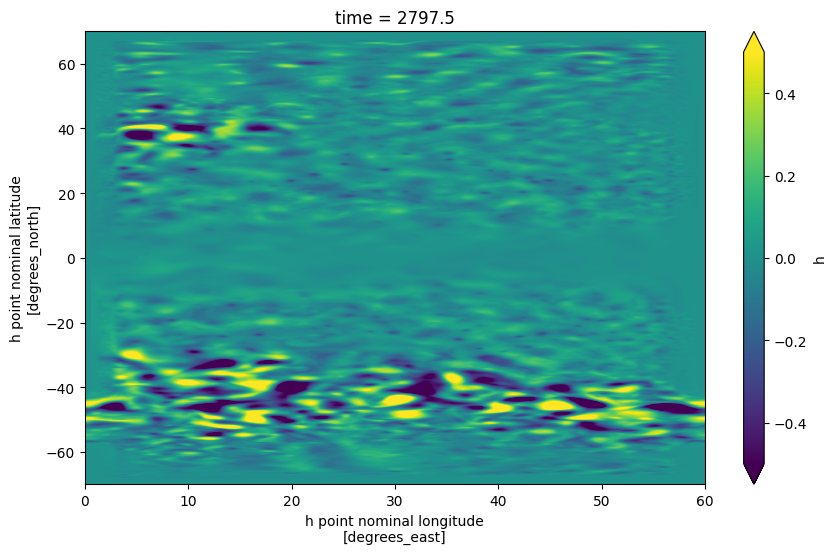

In [27]:
fig, ax = plt.subplots(figsize=(10,6),dpi=100)

SSH[-1:].plot(vmin=-0.5,vmax=0.5)

In [11]:
dSSHdx = SSH.differentiate('xh')*360/(6370000*2*np.pi*np.cos(lat*np.pi/180))
dSSHdy = SSH.differentiate('yh')*360/(6370000*2*np.pi)

In [20]:
numerator = (SSH**2).mean('time'); numerator = numerator.where(numerator>0)
#denominator = (dSSHdx**2+dSSHdy**2).mean('time')
denominator = ((abs(dSSHdy))**2+(abs(dSSHdx))**2).mean('time'); denominator = denominator.where(denominator>0e-20)
scale = ((numerator/denominator)**0.5).mean('xh')
scale.shape

scale[0:160]=np.nan
scale[-160:]=np.nan

(4480,)

In [21]:
scale[0:160]=np.nan
scale[-160:]=np.nan

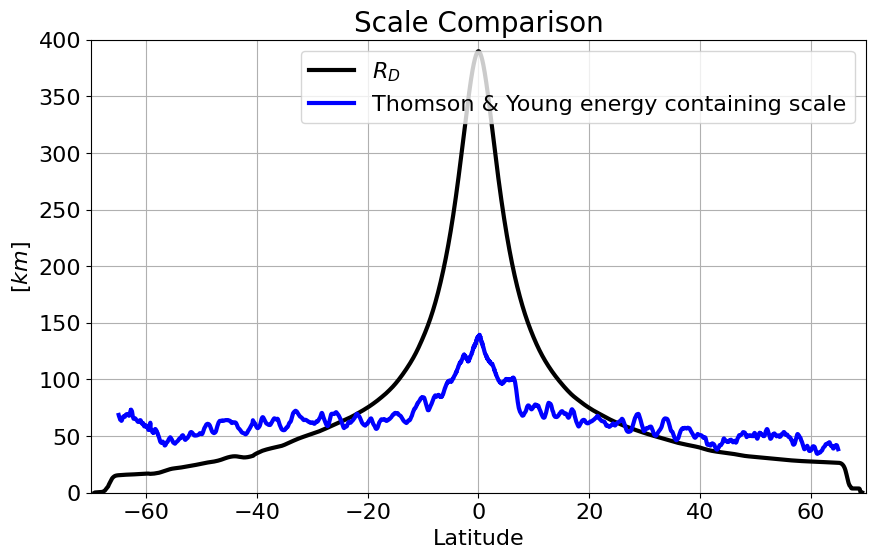

In [22]:

fig, ax = plt.subplots(figsize=(10,6),dpi=100)


plt.plot(Ld.yh,Ld,'-',c='k',linewidth=3,label='$R_D$')
plt.plot(scale.yh,scale/1000,'-',c='b',linewidth=3,label='Thomson & Young energy containing scale')

#plt.plot(ES_wavenumber.yh,1./ES_wavenumber,'-',c='k',linewidth=3,label='$R_E$ - spectral peak')
#plt.fill_between(ES_wavenumber.yh, 1./(ES_wavenumber)+ES_stdev, 1./(ES_wavenumber)-ES_stdev,color=(0.5,0.5,0.5,0.5))


plt.title('Scale Comparison',fontsize=20)
plt.ylim([0, 400]); plt.xticks(fontsize=16);
plt.xlim([-70, 70]); plt.yticks(fontsize=16);
plt.grid()
plt.xlabel('Latitude',fontsize=16); plt.ylabel('$[km]$',fontsize=16);
plt.legend(fontsize=16)

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')